![](https://ga-core.s3.amazonaws.com/production/uploads/program/default_image/5734/thumb_GA_Stack_Large_RedBlack_RGB.png)


# DSI14: Project 4
## Data Industry Job Market Analysis

---
## Executive Summary

### Data Gathering and Broad Statistics
Data industry (DI) job market analysis has been conducted using data gathered from SEEK (seek.com.au), as this is a highly used and trafficked web source for job post in Australia.

Data was gathered by deploying specialised programs, known as Spiders, developed to facilitate scrapping of data from websites. A series of Spiders were deployed to gather data based on specific search terms allowing for a wider net to be cast across the website. The Spiders returned almost 14k jobs ads, however once data cleaning was carried out, the total number of DI job ads collected was approximately 10.5k.

Jobs were search for based on the following broad types; Data Scientist (DS), Data Analyst (DA) and Data Engineer (DE). Across Australia DA roles account for the majority of advertised roles with about 70% of all ads. DS account for a further 25% and DE the final 5%. 
 

### What factors influence salary?
The majority of job postings do not include salary specific information. Only approximately 24% off all ads included information regarding salary. Overall, this equates to approx. 2.4k job ads with salary information, which is a healthy portion of data for analysis.

Although SEEK provides the option to filter based on broad salary bands, it is not clear on what information SEEK uses to filter the ads that do not provide salary information. Given this ambiguity, the salary assessment was carried out on the subset of jobs ads that did include salary info. 

Broadly, highest salaries were seen in Sydney, Melbourne and Canberra. Median salaries across all major capital cities are \\$105-130k per year, except for Adelaide where the median was approximately \\$95k.

In order to determine the factors that influence salary, each job ad was grouped into three (3) groups based on the following ranges:
1.	Low: salary ≤ 97.5k; 
2.	Mid: 97.5k > salary ≤ 135k; and
3.	High: salary > 135k.

Two different classification methods were used to decipher the influencing factors. Although one method (a Decision Tree based model) provided an overall higher classification accuracy, interpretation of the deciding factors between the three salary bands is harder to discern. 

The second method (a Bayesian probabilistic model) performed relatively well with an average classification accuracy 34% higher than the baseline benchmark (68% compared to 34% baseline). Generally, the distinction between the Low and High classes was stronger, where as the model struggled more with the Mid class. This makes sense given that in reality there will be a gradual evolution of skills and responsibilities as roles increase from Junior to more senior roles. This can be seen in the influential terms predicted by the model, with shared skills arising between the Low/Mid classes, and a move towards more accountability and managerial elements between Mid/High.

The following table summarises some of the key industry specific terms that were predicted by the model to be influential.

|LOW | MID | HIGH
|:--- |:--- |:---
SQL experience | SQL experience | Business markerting
Compiling | Effective communication | Engineering solutions
Effective communication | Impact engagement | Objective
Expertise curiosity | Accountable | SaaS


### What factors differentiate Data Scientist vs. Data Analyst roles?
A random sample of the DA job ads was combined with the DS ads to form a subset of approximately 5k job ads to assess whether there are clear differentiating factors between these advertised roles.

Similar to the salary assessment, two different methods were implemented, with one method (a Logistic Regression) providing a solid performance and interpretable results. This method resulted in an overall accuracy 33% above the baseline benchmark (83% compared to 50% baseline). This indicates that there is a clear differentiation between the roles from the ads, however some errors still remain. Given that there are shared skillsets between these roles as well as a potential misunderstanding by the ad authors between the exact differentiation between Scientist and Analyst roles, misclassification errors are to be expected.

The following table summarises some of the key industry specific terms that were predicted by the model to be influential.

|DATA ANALYST | DATA SCIENTIST
|:--- |:--- 
Stakeholders business | Stakeholders relationships
Think outside | Development support
Internal stakeholders | New systems
Solutions data | MS Word






### Next steps
Improvements in the analysis could be achieved by considering the following;
1. Further interrogation of the job ads, removing additional non-DI jobs that are likely adding noise to the data
2. Sift more of the chaff from the job ad descriptions, e.g. remove generic recruitment type terms that are likely adding noise to the data
3. Gather more data! Potentially look to overseas markets or gather more data in the future



---
#### Note to BF:
- it appears that I havent controlled for some randomness in the classifiers, so on a re-run, some of the top features listed changed from what's in the tables above. The tables in the exec summary reflect the presentation.

---

---
## 1.0 Assessment time

Import required libraries

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

sns.set(style='whitegrid', font_scale=1.2)
%matplotlib inline

In [2]:
# set the DF disply to show all columns for EDA
pd.set_option("display.max_columns", None)

pd.set_option('display.html.use_mathjax', False)

### 1.1 Load scraped data and EDA
 - Data gathered in mulitple json files.
 - all separate files loaded and concatenated together

In [3]:
# Load the data scientist (DS) json data file to initiate a DF
seek_data = pd.read_json('./seek_scrape/data_scientist.json')

In [4]:
# Load and join all other json files to form one main DF
files = ['data_analyst_act.json', 'data_analyst_nsw.json', 'data_analyst_qld.json', 'data_analyst_sa.json',
         'data_analyst_ta.json', 'data_analyst_vic.json', 'data_analyst_wa.json', 'data_engineer.json']

# loop city - load and append all other json files
for i in range(len(files)):
    new_file = './seek_scrape/' + files[i]
    new_df = pd.read_json(new_file)
    
    # concat the DFs to main ensuring to ignore the indice stuff
    seek_data = pd.concat([seek_data, new_df], axis=0, ignore_index=True)


#seek_data.reindex()
seek_data.shape    #checking the total shape

(13816, 11)

In [5]:
seek_data.head()

,search,job_title,company,location_1,location_2,sector_1,sector_2,work_type,salary,desc,url
0,Data Scientist,Data Scientist / Data Consultant,Wood.,Perth,"CBD, Inner & Western Suburbs",Information & Communication Technology,Consultants,Full Time,None,[Wood is currently recruiting for an experienc...,https://www.seek.com.au/job/52538666?type=prom...
1,Data Scientist,Data Scientist,Suncorp,Sydney,Information & Communication Technology,Information & Communication Technology,Other,Full Time,Competitive salary on offer,"[About the role, \n, Suncorp believes in the v...",https://www.seek.com.au/job/52556766?type=stan...
2,Data Scientist,Data Engineer,MYOB,Melbourne,CBD & Inner Suburbs,Information & Communication Technology,Engineering - Software,Full Time,Attractive salary and employee benefits,"[Who are we?, MYOB is a business platform. Ou...",https://www.seek.com.au/job/52573414?type=stan...
3,Data Scientist,Data Scientist,Michael Page Information Technology,Melbourne,CBD & Inner Suburbs,Information & Communication Technology,Database Development & Administration,Contract/Temp,$115k - $130k p.a.,[We are looking for a Data Scientist/Analyst w...,https://www.seek.com.au/job/52570854?type=stan...
4,Data Scientist,Data Business Analyst,REA Group,Melbourne,CBD & Inner Suburbs,Information & Communication Technology,Business/Systems Analysts,Full Time,None,"[ , The safety and wellbeing of our employees ...",https://www.seek.com.au/job/52574076?type=stan...


In [6]:
# function to parse out the Seek job ad ID number from the url
def grab_job_id(url):
    id_num = re.findall('\d+', url)
    return int(id_num[0])

In [7]:
# process the 'url' series and parse out all job ad IDs
seek_data['job_id'] = seek_data['url'].apply(grab_job_id) 

In [8]:
# drop any duplicates based on the job_id - NB the SEEK id is assumed to be unique to each ad
seek_data = seek_data.drop_duplicates(subset=['job_id'], ignore_index=True)
seek_data.shape

(11391, 12)

In [9]:
# SEEK ad construction led to some duplicated data between the 'Sector' & 'Location' cols
# remove duplicated info grabbed
seek_data['location_2'] = seek_data.apply(lambda x: None if x['location_2'] == x['sector_1'] else x['location_2'], axis=1)

#### Salary parse success

Function to handle the salary information scraped from SEEK. Function recieves a list of salary strings (fed as a pd.Series) and then parses out the numeric values found and tracks the format used, i.e. numeric with/without comma seperator, shorthand noted with a 'k'

In summary the function process flows as follows;
1. Form a list of salary values;
    - Regex used to ident all numeric values and add these to a list
    - Regex used to ident any number followed by the shorthand 'k' - add to separate list for reference
    - Regex used to ident any number followed by a '%' symbol, assumed to be a super value, and removed from the main list of numbers
    - Very large or very low numbers ignored to capture random phone numbers and other non salary values.
2. Work through the formulated salary number list;
    - if a number also exits in the 'k-list' are separate and refactored to '000' and added to new 'sal list'
    - any remaining numbers in main num list added to 'sal list'
    - 'sal list' sorted
    - if length 'sal list' > 1, then assume a range has been provided. Grab low/high and calc a mid-point. if only 1 value, assign as mid-point
    - conditionals included to check for erroneous magnitude differences between low/high values. Refactor to align values to same magnitude
    - if no numbers left in num-list, all numeric values in string are not related to salary values. Assign 'None' to values.
3. Parse out the pay period from the salary string
4. based on the pay period, calculate and annual equivalent salary.
    - assume all roles are full-time
5. append values to separate lists
6. Once main loop complete, add lists to a dictionary and return this



[NB this function grew to a behemouth as it evolved to handle all the various inane ways job ads wrote the salary info. In practice, I would have broken this up into separate smaller, easier to handle functions, that would be work together]

In [10]:
def salary_parse(salary_list):
    low_br, mid_pt, hi_br = [], [] ,[]
    pay_period = []
    annual_eq = []
    salary_par = {}
    
    # search terms for parsing out the pay period
    day_chk = ['p/d', 'pd', 'day', 'p.d', 'daily']
    hour_chk = ['p/h', 'hour', 'ph', 'p.h', 'hr']
    fort_chk = ['p/f', 'p.f']
    
    for i, j in enumerate(salary_list):
        super_vals = []
        sals = []
        tbr = []

        if j != None:
            # check for any number and grab into a list
            num_list = re.findall('\d+\.\d+|\d+', j.replace(',','').replace(' ',''))   
            
            # check for ints followed by 'k' preceded by whitespace and add to separate list
            k_vals = re.findall('\d+(?=k|K)|\d+\s+(?=k|K)|\d+(?=-\d+[kK])', 
                                j.replace(',','').replace(' ','').replace("/",'-'))    
            
            # check for and remove any super vals
            super_vals = re.findall('\d+\.\d+(?=%)|\d+(?=%)', j)     # find all floats followed by '%'
            if len(super_vals) != 0:
                # then there is a 'X%' number in there - assume only one value
                num_list.remove(super_vals[0])

            # grab any misc large numbers (i.e phone) or low numbers that might not be relavent
            for a in range(len(num_list)):
                if float(num_list[a]) < 20 or float(num_list[a]) > 500000:
                    if num_list[a] not in k_vals:
                        tbr.append(num_list[a])

            # remove values listed in the 'to be removed / tbr' list
            num_list = [num_list[x] for x in range(len(num_list)) if num_list[x] not in tbr]

            
            '''work through list of numbers and seperate out low/mid/high range and/or calc mid'''
            if len(num_list) != 0:
                #there's numbers in there
                if len(k_vals) != 0:
                    # then there is at least one number identified with a 'k/K'
                    sals = [float(x) * 1000 for x in k_vals]
                    for x in range(len(k_vals)):
                        num_list.remove(k_vals[x].strip())   # remove from the list of all numbers

                if len(num_list) != 0:
                    #theres still number to sort out
                    num_list = [float(j) for j in num_list]     # convert vals to float
                    sals = sals + num_list

                sals = sorted(sals, reverse=False)    # sort the stored salary numbers
                if len(sals) == 1:
                    # only one value in list
                    low, hi = None, None
                    if (float(sals[0])) / 100000 > 10:
                        #some moron left a 'k' next to a real salary value
                        mid = float(sals[0]) / 1000    # refactor to actual
                    else:
                        mid = float(sals[0])
                else:
                    #length of list unknown use the extents of sorted list to grab hi and low
                    low, hi = float(sals[0]), float(sals[-1])
                    if (hi/100000) > 10:
                        #some moron left a 'k' next to a real salary value - only spotted on 'hi' vals in tests
                        hi = hi / 1000    # refactor to actual                    
                    if (hi / low) > 3:
                        #order of magnitude issue between values - assume misreading/mistyped lower val
                        #and set all vals to the 'hi'
                        low, mid = hi, hi
                    else:
                        mid = (hi + low) /2    # values parsed properly so assign the mean                     
                    
            else:
                # no useful vals in string 
                low, mid, hi = None, None, None

            '''Peel out the pay period from the salary string'''
            # Parse out the pay period
            flag = False
            for x in range(len(day_chk)):
                if day_chk[x] in j.lower() and flag == False:
                    period = 'Day'
                    flag = True
                    try:
                        if (mid / 1000) > 2:
                            # mislabled, value is 5-6figures - assume should be Annual
                            period = 'Annual'
                    except:
                        pass
            for y in range(len(hour_chk)):
                if hour_chk[y] in j.lower() and flag == False:
                    period = 'Hour'
                    flag = True
                    try:
                        if (mid / 1000) > 2:
                            # mislabled, value is 5-6figures - assume should be Annual
                            period = 'Annual'
                    except:
                        pass
            for z in range(len(fort_chk)):
                if fort_chk[z] in j.lower() and flag == False:
                    period = 'Fort'
                    flag = True
            if flag == False:
                # assume that if all else fails, its an per annun pay period
                period = 'Annual'
                #print(mid, i, j)
                try:
                    if (mid / 100) < 2:
                        # value is less than 200, assume it should be a factor of 1000 larger
                        low = low * 1000
                        mid = mid * 1000
                        hi = hi * 1000
                except:
                    pass
            
            '''calc the equivalent annual salary based on pay period'''
            # calculate an annual ft equivalent salary
            if period == 'Hour':
                # assume FT is 40hr wk and 52wks per yr
                try:
                    fte = mid * 40 * 52
                except:
                    fte = None
            elif period == 'Day':
                # assume FT is 5 day wk and 52wks per yr
                try:
                    fte = mid * 5 * 52
                except:
                    fte = None
            elif period == 'Fort':
                # assume FT is 26 fortnights per yr
                try:
                    fte = mid * 26
                except:
                    fte = None
            else:
                # period is Annual so just grab mid
                try: fte = mid
                except: fte = None

        else:
            low, mid, hi = None, None, None
            period = 'Annual'
            fte = None

        # append calculated values to lists
        low_br.append(low)
        mid_pt.append(mid)
        hi_br.append(hi)
        pay_period.append(period)
        annual_eq.append(fte)
        
    # generate dict of lists created
    salary_par = {'Low_bracket': low_br, 'Mid_point': mid_pt, 'High_bracket': hi_br, 
                  'Period': pay_period, 'Annual_eq': annual_eq}
 
    return salary_par

In [11]:
# create salary info DF by calling the salary parse function
sal_df = pd.DataFrame(salary_parse(seek_data['salary']))
sal_df.head()

,Low_bracket,Mid_point,High_bracket,Period,Annual_eq
0,NaN,NaN,NaN,Annual,NaN
1,NaN,NaN,NaN,Annual,NaN
2,NaN,NaN,NaN,Annual,NaN
3,115000.0,122500.0,130000.0,Annual,122500.0
4,NaN,NaN,NaN,Annual,NaN


In [12]:
# check that shapes are consistent
seek_data.shape, sal_df.shape

((11391, 12), (11391, 5))

In [13]:
# join base SEEK df with the parsed salary info
seek_all = pd.concat([seek_data, sal_df], axis=1)
seek_all.head()

,search,job_title,company,location_1,location_2,sector_1,sector_2,work_type,salary,desc,url,job_id,Low_bracket,Mid_point,High_bracket,Period,Annual_eq
0,Data Scientist,Data Scientist / Data Consultant,Wood.,Perth,"CBD, Inner & Western Suburbs",Information & Communication Technology,Consultants,Full Time,None,[Wood is currently recruiting for an experienc...,https://www.seek.com.au/job/52538666?type=prom...,52538666,NaN,NaN,NaN,Annual,NaN
1,Data Scientist,Data Scientist,Suncorp,Sydney,None,Information & Communication Technology,Other,Full Time,Competitive salary on offer,"[About the role, \n, Suncorp believes in the v...",https://www.seek.com.au/job/52556766?type=stan...,52556766,NaN,NaN,NaN,Annual,NaN
2,Data Scientist,Data Engineer,MYOB,Melbourne,CBD & Inner Suburbs,Information & Communication Technology,Engineering - Software,Full Time,Attractive salary and employee benefits,"[Who are we?, MYOB is a business platform. Ou...",https://www.seek.com.au/job/52573414?type=stan...,52573414,NaN,NaN,NaN,Annual,NaN
3,Data Scientist,Data Scientist,Michael Page Information Technology,Melbourne,CBD & Inner Suburbs,Information & Communication Technology,Database Development & Administration,Contract/Temp,$115k - $130k p.a.,[We are looking for a Data Scientist/Analyst w...,https://www.seek.com.au/job/52570854?type=stan...,52570854,115000.0,122500.0,130000.0,Annual,122500.0
4,Data Scientist,Data Business Analyst,REA Group,Melbourne,CBD & Inner Suburbs,Information & Communication Technology,Business/Systems Analysts,Full Time,None,"[ , The safety and wellbeing of our employees ...",https://www.seek.com.au/job/52574076?type=stan...,52574076,NaN,NaN,NaN,Annual,NaN


In [14]:
seek_all.shape

(11391, 17)

In [15]:
# grabthe col names
seek_all.columns

Index(['search', 'job_title', 'company', 'location_1', 'location_2',
       'sector_1', 'sector_2', 'work_type', 'salary', 'desc', 'url', 'job_id',
       'Low_bracket', 'Mid_point', 'High_bracket', 'Period', 'Annual_eq'],
      dtype='object')

In [16]:
# generate list of col names for re-ordering of DF to more readable format
new_cols = ['job_id', 'search', 'job_title', 'company', 'location_1', 'location_2', 'sector_1',
       'sector_2', 'work_type', 'Period', 'Low_bracket', 'Mid_point', 'High_bracket', 'salary', 'Annual_eq', 'desc', 'url']

In [17]:
# reorder the columns
seek_all = seek_all[new_cols]
seek_all.head(2)

,job_id,search,job_title,company,location_1,location_2,sector_1,sector_2,work_type,Period,Low_bracket,Mid_point,High_bracket,salary,Annual_eq,desc,url
0,52538666,Data Scientist,Data Scientist / Data Consultant,Wood.,Perth,"CBD, Inner & Western Suburbs",Information & Communication Technology,Consultants,Full Time,Annual,NaN,NaN,NaN,None,NaN,[Wood is currently recruiting for an experienc...,https://www.seek.com.au/job/52538666?type=prom...
1,52556766,Data Scientist,Data Scientist,Suncorp,Sydney,None,Information & Communication Technology,Other,Full Time,Annual,NaN,NaN,NaN,Competitive salary on offer,NaN,"[About the role, \n, Suncorp believes in the v...",https://www.seek.com.au/job/52556766?type=stan...


In [18]:
# check stats on how many salary values have been captured
print("Sal figures count: ",seek_all.shape[0] - seek_all['Mid_point'].isna().sum())
print("% Sal figures:     ", round((1 - seek_all['Mid_point'].isna().sum() / seek_all.shape[0])*100,1))

Sal figures count:  2706
% Sal figures:      23.8


In [19]:
# check on general stats
seek_all.describe().T

,count,mean,std,min,25%,50%,75%,max
job_id,11391.0,5.245050e+07,94506.285743,50028407.00,52388811.0,52461866.00,52520347.50,52584718.0
Low_bracket,2138.0,7.626879e+04,49953.850174,20.00,50000.0,84552.50,110000.00,370791.0
Mid_point,2706.0,8.205885e+04,56990.530694,21.32,27499.5,90000.00,120000.00,400000.0
High_bracket,2138.0,9.098916e+04,60139.411598,28.24,59999.0,99999.00,130000.00,450000.0
Annual_eq,2706.0,1.249434e+05,73022.162713,28.00,86856.5,113015.75,147779.75,1872000.0


In [20]:
# create function to clean up the description data. Removes spurious unicode chars that got scraped

def desc_clean(desc_str):
    # desc_str comes in as a list so join all list elements to one str
    cleaned_str = ' '.join(desc_str)
    
    #remove weirdo unicode chars -- only method I've tried that worked!
    cleaned_str = ' '.join(cleaned_str.split())
    
    return cleaned_str

In [21]:
# apply clean function to the description text
seek_all['desc'] = seek_all['desc'].map(desc_clean)

In [22]:
# remove some obvious non relevant jobs based on industry

seek_all = seek_all[(seek_all.sector_1 != 'Hospitality & Tourism') & 
                    (seek_all.sector_1 != 'Farming, Animals & Conservation') &
                    (seek_all.sector_1 != 'Healthcare & Medical') & 
                    (seek_all.sector_1 != 'Human Resources & Recruitment') & 
                    (seek_all.sector_1 != 'Self Employment')]

#scope out remaiing DF size
seek_all.shape

(10591, 17)

#### Salary brackets
- Need to divide the data up into salary brackets for the first part of the assessment.


In [23]:
# Check for 3 possible bands to see what a balanced set would be divided by
bandA = 97500
bandB = 135000

grp01 = len(seek_all[(seek_all['Annual_eq'] <= bandA)])
grp02 = len(seek_all[(seek_all['Annual_eq'] > bandA) & (seek_all['Annual_eq'] <= bandB)])
grp03 = len(seek_all[(seek_all['Annual_eq'] > bandB)])

print("Total:\t\t", grp01+grp02+grp03, '\nGroup LOW:\t',grp01,'\nGroup MID:\t', grp02,'\nGroup HIGH:\t', grp03)

Total:		 2529 
Group LOW:	 874 
Group MID:	 838 
Group HIGH:	 817


In [24]:
# Check for 2 possible bands around a 6-figure change in salary
bandA = 100000

grpLO = len(seek_all[(seek_all['Annual_eq'] <= bandA)])
grpHI = len(seek_all[(seek_all['Annual_eq'] > bandA)])

print("Total:\t\t", grpLO+grpHI, '\nGroup LOW:\t',grpLO,'\nGroup HIGH:\t', grpHI)

Total:		 2529 
Group LOW:	 955 
Group HIGH:	 1574


>- Breaking the salary up into 3 balanced bands appears to be a good set-up for the classification assessment and mirrors expectations in potential salary growth through the industry

In [25]:
# Create function function to determine the salary bracket based on the $$ value
def salary_band(value):
    if value > 0:
        if value <= 97500:
            band = 0
        elif (value > 97500) & (value <= 135000):
            band = 1
        else:
            band = 2
    else:
        band = None
    
    return band

In [26]:
# map salary bracket function onto DF
seek_all['sal_band'] = seek_all['Annual_eq'].map(salary_band)

In [27]:
# check salary band addition
seek_all.head(3)

,job_id,search,job_title,company,location_1,location_2,sector_1,sector_2,work_type,Period,Low_bracket,Mid_point,High_bracket,salary,Annual_eq,desc,url,sal_band
0,52538666,Data Scientist,Data Scientist / Data Consultant,Wood.,Perth,"CBD, Inner & Western Suburbs",Information & Communication Technology,Consultants,Full Time,Annual,NaN,NaN,NaN,None,NaN,Wood is currently recruiting for an experience...,https://www.seek.com.au/job/52538666?type=prom...,NaN
1,52556766,Data Scientist,Data Scientist,Suncorp,Sydney,None,Information & Communication Technology,Other,Full Time,Annual,NaN,NaN,NaN,Competitive salary on offer,NaN,About the role Suncorp believes in the value a...,https://www.seek.com.au/job/52556766?type=stan...,NaN
2,52573414,Data Scientist,Data Engineer,MYOB,Melbourne,CBD & Inner Suburbs,Information & Communication Technology,Engineering - Software,Full Time,Annual,NaN,NaN,NaN,Attractive salary and employee benefits,NaN,Who are we? MYOB is a business platform. Our p...,https://www.seek.com.au/job/52573414?type=stan...,NaN


In [28]:
# double check balance of bracket definition - tweak the $$ values if unbalanced
seek_all['sal_band'].value_counts()

0.0    874
1.0    838
2.0    817
Name: sal_band, dtype: int64

#### Save output to a csv for manual scope-age

In [29]:
# #output to CSV
# seek_all.to_csv('seek_ALL.csv', index=False)

---
# 3.0 Question 1:

## Q: What are the factors that influence/impact salary

![](https://miro.medium.com/max/2048/0*TgZkMYFmunxKSFgR.png)


#### Notes:

- It should be noted that due to irregular job ad salary contents, some anomolous information is still slipping through the salary parsing method. 
- These will be cull out of the dataset for the assessment by removing erroneous low and super high values.

In [30]:
# copy the main cleaned DF
seek_wt_sal = seek_all.copy()

In [31]:
# check out the 99th percentile value in the parsed annual equivalent
q_up = seek_wt_sal['Annual_eq'].quantile(0.99)
q_mid= seek_wt_sal['Annual_eq'].quantile(0.5)
q_up, q_mid

(286000.0, 114999.5)

In [32]:
# drop the rows with missing/blank salary values
seek_wt_sal = seek_wt_sal[seek_wt_sal['Annual_eq'].notna()]

# drop the super low and super high values
seek_wt_sal = seek_wt_sal.drop(seek_wt_sal[(seek_wt_sal['Annual_eq'] < 25000) | (seek_wt_sal['Annual_eq'] > 300000)].index)
seek_wt_sal.shape

(2476, 18)

In [33]:
# check the baseline for the salary brackets
seek_wt_sal['sal_band'].value_counts(normalize=True)

0.0    0.338449
1.0    0.338449
2.0    0.323102
Name: sal_band, dtype: float64

> **Baseline accuracy** for classification = **34%**

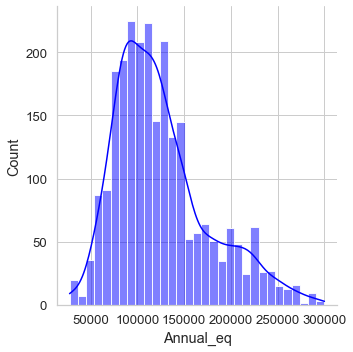

In [34]:
# plot the distribution of all salary information in the dataset
sns.displot(data=seek_wt_sal['Annual_eq'], color='#0000ff', kde=True);

In [35]:
# slice out data for all major capital cities for focus on intersting broad stats
snapshot = seek_wt_sal[['Annual_eq','location_1']][(seek_wt_sal['location_1'] == 'Sydney') | 
                                                   (seek_wt_sal['location_1'] == 'Melbourne') |
                                                   (seek_wt_sal['location_1'] == 'Brisbane') |
                                                   (seek_wt_sal['location_1'] == 'Perth') |
                                                   (seek_wt_sal['location_1'] == 'Adelaide') |
                                                   (seek_wt_sal['location_1'] == 'Hobart') |
                                                   (seek_wt_sal['location_1'] == 'ACT')]
snapshot.shape

(2310, 2)

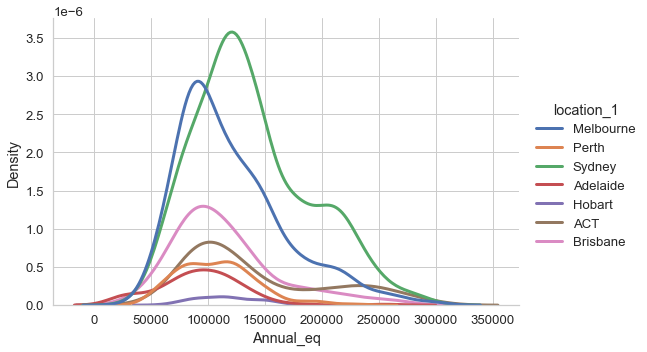

In [36]:
# plot denisty dist of capital city salaries
sns.displot(data=snapshot, x= 'Annual_eq', hue='location_1', kind='kde', aspect=1.5, lw=3);

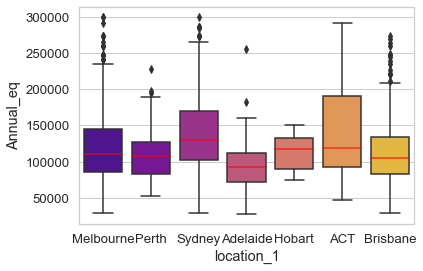

In [37]:
# boxplot dist of capital city salaries
sns.boxplot(x=snapshot['location_1'], 
            y=snapshot['Annual_eq'], 
            palette='plasma',
            medianprops=dict(color="red", alpha=0.7));

In [38]:
# calc the median salaries for each capital city and output for broad statistic review
med_sals = [np.median(snapshot[snapshot['location_1'] == x]['Annual_eq']) for x in set(snapshot.location_1)]
print(set(snapshot.location_1))
med_sals

{'Sydney', 'Perth', 'Adelaide', 'Melbourne', 'ACT', 'Brisbane', 'Hobart'}


[129999.5, 108066.5, 93250.0, 110000.0, 118522.0, 104756.5, 117096.5]

In [39]:
seek_wt_sal.head(2)

,job_id,search,job_title,company,location_1,location_2,sector_1,sector_2,work_type,Period,Low_bracket,Mid_point,High_bracket,salary,Annual_eq,desc,url,sal_band
3,52570854,Data Scientist,Data Scientist,Michael Page Information Technology,Melbourne,CBD & Inner Suburbs,Information & Communication Technology,Database Development & Administration,Contract/Temp,Annual,115000.0,122500.0,130000.0,$115k - $130k p.a.,122500.0,We are looking for a Data Scientist/Analyst wi...,https://www.seek.com.au/job/52570854?type=stan...,1.0
5,52547469,Data Scientist,Data Analyst,Robert Half Technology,Perth,"CBD, Inner & Western Suburbs",Information & Communication Technology,Business/Systems Analysts,Full Time,Annual,85000.0,90000.0,95000.0,$85k - $95k p.a.,90000.0,The Company Our client is a leading company th...,https://www.seek.com.au/job/52547469?type=stan...,0.0


In [40]:
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.model_selection import train_test_split
# from sklearn import metrics
# from sklearn.metrics import confusion_matrix, classification_report

# from sklearn.linear_model import SGDClassifier, LogisticRegression
# from sklearn import svm
# from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
# from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# #from sklearn.linear_model import LogisticRegression

# from sklearn.pipeline import Pipeline

#### Define the Feature and Target variables and then split Train/Test

In [41]:
# Feature and Targets
X = seek_wt_sal.desc
y = seek_wt_sal.sal_band

# Splitsville
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=44)

X_train.shape, X_test.shape

((1857,), (619,))

#### Model function:

In [42]:
## Define a MulitnomialNB model function that takes a vectoriser and 
## outputs model accuracy and formatted confusion matrix and classification report

def go_time(vector):
    #dtm's
    X_train_dtm = vector.fit_transform(X_train)    # Fit>Transform TRAIN data
    X_test_dtm = vector.transform(X_test)    # Transform TEST data
    print("Shape of Train DS: ", X_train_dtm.shape)
    
    # use Naive Bayes 
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    
    #predictions
    y_pred_class = nb.predict(X_test_dtm)    # test data
    
    # calculate accuracy
    print("TEST Classification acc:\t",round(metrics.accuracy_score(y_test, y_pred_class),3),'\n\n')
    
    # conf matrix on the TEST DATA
    conmat = confusion_matrix(y_test, y_pred_class)
    conf_df = pd.DataFrame(conmat, index=nb.classes_, columns=nb.classes_)
    #print out the Classification rpt
    print(classification_report(y_test, y_pred_class))

    return conf_df

---
### 3.1.1 Classification model 01

- Utilising Sklearn's Pipeline, NLP transformer and classifier model has been combined with a GridSearch CV
- A Naive-Bayes model has been considered for the base classifier assessment.
- The job description text has been tokenised using the CountVectoriser. During initial trials, this offered the best model outcomes.
    - Hyper-parameters of the CountVectoriser have been searched to optimise performance.
    - limitations on the minimum documents that words occur in was considered to reduce the possibility of rare words affecting performance (Tested: [3,4,5])
    - a max document occurence was included to minimise the possibility of frequent common words affecting model performance (Tested: [0.05, 0.075, 0.1, 0.15])
    - ngrams considered to capture posibility of joined words being relevant (Tested: [(1,1),(1,2)]).

> **Note to BF**: I have manually limited the grid parameters to match the best parameters found during the initial modelling to save on computation time

In [43]:
# pipeline set up with tokeniser and the classifier
pipe_nb = Pipeline([('vect', CountVectorizer(stop_words='english')), ('clf', MultinomialNB())])

pipe_nb_params = {'vect__max_df': [0.05],
                  'vect__min_df': [5],
                  'vect__ngram_range': [(1,2)],
                  'vect__max_features': [10000]
                 }

nb_grid = GridSearchCV(pipe_nb, pipe_nb_params, cv=5)
nb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(stop_words='english')),
                                       ('clf', MultinomialNB())]),
             param_grid={'vect__max_df': [0.05], 'vect__max_features': [10000],
                         'vect__min_df': [5], 'vect__ngram_range': [(1, 2)]})

In [44]:
# check on the best parameters
nb_grid.best_params_

{'vect__max_df': 0.05,
 'vect__max_features': 10000,
 'vect__min_df': 5,
 'vect__ngram_range': (1, 2)}

In [45]:
# print out the best score from the Training dataset
print("Best score from TRAIN data:\t", round(nb_grid.best_score_, 3))

# load the Grid outputs into a DF and isolate the best estimator outputs and check the X-fold results
nb_grid_results = pd.DataFrame(nb_grid.cv_results_)
nb_grid_results.iloc[:,9:][nb_grid_results['rank_test_score'] == 1]

Best score from TRAIN data:	 0.666


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.696237,0.674731,0.6469,0.673854,0.638814,0.666107,0.020765,1


In [46]:
## Score the TEST data set
nb_best = nb_grid.best_estimator_
y_pred_class = nb_best.predict(X_test)

# derive the confusion matrix on the TEST DATA
conmat = confusion_matrix(y_test, y_pred_class)
conf_df = pd.DataFrame(conmat, index=['low','Mid','High'], columns=['low','Mid','High'])

#print out the Classification rpt
print("--------Classification Results for TEST data--------\n")
print(classification_report(y_test, y_pred_class))
conf_df

--------Classification Results for TEST data--------

              precision    recall  f1-score   support

         0.0       0.73      0.79      0.76       210
         1.0       0.65      0.47      0.55       209
         2.0       0.64      0.77      0.70       200

    accuracy                           0.68       619
   macro avg       0.67      0.68      0.67       619
weighted avg       0.67      0.68      0.67       619



,low,Mid,High
low,166,28,16
Mid,40,98,71
High,22,24,154


#### Notes on model performance:
> - The mean TRAIN score is clearly either evil or an Iron Maiden fan, which is acceptable.
> - reviewing the cross-fold scores from the training shows that overall the model has relatively low variance but is biased
> - the average TEST accuracy mirrors this performance with a score in the same range (so low variance) but is still far from the truth (biased)
> - the model performs better on the Low (0) and High (2) classes, but under-performs on the Mid (1) class. This makes sense given that Low/High will be more diametrically opposed in their differences, where as there would be a lot of shared role reuirements between the Mid class and the others.

In [47]:
# access the grid pipeline chain to get the feature probabiliy scores and the vectorised vocabulary
feat_probs = nb_grid.best_estimator_.named_steps['clf'].feature_log_prob_
feat_names = nb_grid.best_estimator_.named_steps['vect'].vocabulary_

# chuck the log-prob for all features into a DF
feat_importance = pd.DataFrame(data = {'Class_0': feat_probs[0], 'Class_1': feat_probs[1], 'Class_2':feat_probs[2]},
                              index=feat_names)

# convert log-probabilities to probabilities
feat_importance = feat_importance.applymap(lambda x: np.exp(x))

In [48]:
# sorted list of top features for class 0 / Low salary
low_top_feats = feat_importance['Class_0']
low_top_feats = low_top_feats.sort_values(ascending=False)
low_top_feats.head(20)

potentially                0.001834
sql experience             0.001813
compiling                  0.001656
ability influence          0.001261
accountable transparent    0.001188
partnerships               0.001052
aarnet                     0.000990
expertise curiosity        0.000969
orientation                0.000938
customer issues            0.000906
effective communication    0.000896
complex business           0.000886
presence                   0.000865
activities required        0.000854
careers applications       0.000823
combination relevant       0.000823
complex data               0.000802
responsible fees           0.000792
technical leadership       0.000792
services meet              0.000781
Name: Class_0, dtype: float64

In [49]:
# create a function to crete a wordcloud from a given list

from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=30,
        max_font_size=40, 
        scale=3,
        collocation_threshold = 1,
        random_state= 4,
        width= 400,
        height=400
    ).generate(str(data))

    fig = plt.figure(figsize=(7, 7))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)

    plt.imshow(wordcloud)
    plt.show()


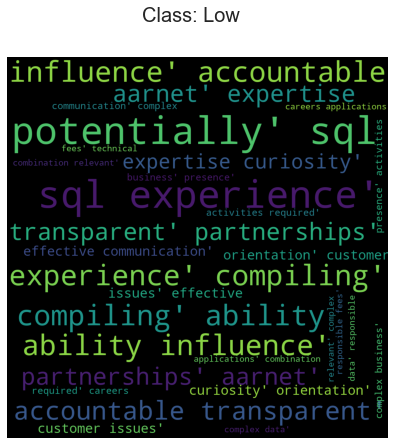

In [50]:
# generate wordcloud for Low salary class
show_wordcloud(low_top_feats.index.values[:30], title="Class: Low")

In [51]:
# top features for class 1 / Mid salary
mid_top_feats = feat_importance.sort_values(by=['Class_1'], ascending=False)
mid_top_feats.head(20)

,Class_0,Class_1,Class_2
potentially,0.001834,0.001513,0.000422
process email,0.000719,0.001406,0.000253
compiling,0.001656,0.001374,0.000365
jobs enquiries,0.000500,0.001257,0.001391
assumptions,0.000490,0.001140,0.000365
sql experience,0.001813,0.000916,0.000408
health research,0.000417,0.000852,0.000169
aarnet,0.000990,0.000831,0.000183
effective communication,0.000896,0.000810,0.000422
impact engagement,0.000219,0.000788,0.000155


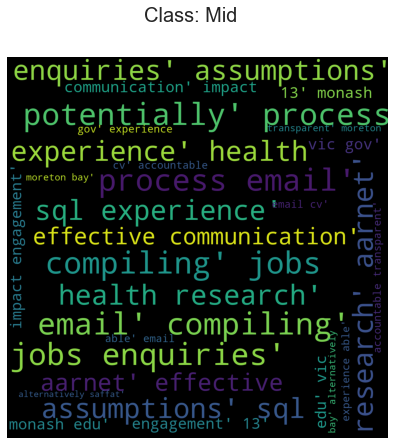

In [52]:
# wordcloud for the mid-salary class
show_wordcloud(mid_top_feats.index.values[:30], title="Class: Mid")

In [53]:
# top features for class 2 / High salary
high_top_feats = feat_importance.sort_values(by=['Class_2'], ascending=False)
high_top_feats.head(20)

,Class_0,Class_1,Class_2
alternatively saffat,0.000406,0.000661,0.001546
jobs enquiries,0.000500,0.001257,0.001391
objective,0.000021,0.000139,0.001237
business marketing,0.000063,0.000202,0.001138
offer great,0.000094,0.000384,0.001040
internet,0.000042,0.000309,0.001026
saas,0.000104,0.000479,0.001026
briefings,0.000104,0.000320,0.000984
literacy,0.000250,0.000309,0.000970
interesting,0.000135,0.000426,0.000970


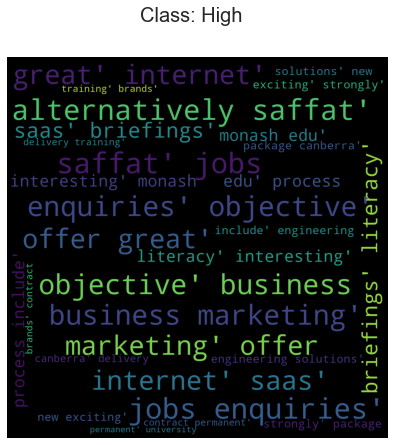

In [54]:
# wordcloud for the high-salary class
show_wordcloud(high_top_feats.index.values[:30], title="Class: High")

### 3.1.2 Classification model 02 - Tree based classification

- RandomForest model selected to limit potential issues of overfitting with a base DecisionTree
- Job description re-vectorised with identical parameters as first classification to focus on the distinct differences in model performance only
    - Note this was done for education and interest. In practice hyperparameters would be have been re-tuned to optimise the RF classifier performance

In [55]:
# Set up a vectoriser with the same params as the Naive Bayes
vector_tree = CountVectorizer(stop_words='english', max_df=0.05, max_features=10000, min_df=5, ngram_range=(1,2))

# down-to-matrix.... dtm's
X_train_dtm_tree = vector_tree.fit_transform(X_train)    # Fit>Transform TRAIN data
X_test_dtm_tree = vector_tree.transform(X_test)    # Transform TEST data

print(X_train_dtm_tree.shape)

(1857, 10000)


In [56]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=1000, oob_score=True)

# cross-val the RF to check on the variance in performance
forest_scores = cross_val_score(rfc,X_train_dtm_tree, y_train, cv=5)
print("------TRAIN X-fold summary output ------")
print("Cross-fold scores: ",forest_scores)
print("Mean score:\t",round(np.mean(forest_scores),5))
print("St-dev:\t\t",round(np.std(forest_scores),5))
print("Var:\t\t",np.var(forest_scores))

------TRAIN X-fold summary output ------
Cross-fold scores:  [0.71236559 0.67741935 0.68733154 0.70889488 0.64150943]
Mean score:	 0.6855
St-dev:		 0.02558
Var:		 0.0006545803032858633


In [57]:
# fit the model on the full train set
rfc.fit(X_train_dtm_tree, y_train)


RandomForestClassifier(n_estimators=1000, oob_score=True)

In [58]:
# Test the model performance on the TEST dataset
forest_pred = rfc.predict(X_test_dtm_tree)
forest_score = rfc.score(X_test_dtm_tree, y_test)
print("RF Test score:", forest_score)

# confusion matrix on the TEST DATA
conmat = confusion_matrix(y_test, forest_pred)
conf_df = pd.DataFrame(conmat, index=['low','Mid','High'], columns=['low','Mid','High'])

#print out the Classification rpt
print("\n--------Classification Results for TEST data--------\n")
print(classification_report(y_test, forest_pred))

conf_df

RF Test score: 0.715670436187399

--------Classification Results for TEST data--------

              precision    recall  f1-score   support

         0.0       0.71      0.84      0.77       210
         1.0       0.70      0.56      0.62       209
         2.0       0.73      0.76      0.74       200

    accuracy                           0.72       619
   macro avg       0.71      0.72      0.71       619
weighted avg       0.71      0.72      0.71       619



,low,Mid,High
low,176,27,7
Mid,45,116,48
High,26,23,151


#### Notes on model performance:
> - Reviewing the cross-fold scores from the training shows that overall the model has a slight increase in variance compared to the NaiveBayes model, however the bias is slightly improved with scores edging closer to the truth.
> - The average TEST accuracy mirrors this performance.
> - The model performs much better on the Low (0) and High (2) classes, and improves on the classification of the Mid (1) level. Conseuently there is a reduced number of Type 1 & 2 errors which is better for a classification problem.
> - However, deciphering the Features of importance that will provide insights regarding each class is difficult from this model.

In [59]:
# chuck the features importance values into a DF
rfc_feature_import = pd.DataFrame(data={'importance':rfc.feature_importances_}, index=vector_tree.vocabulary_)

# sort the DF to review the top features
rfc_feature_import.sort_values(by='importance', ascending=False, inplace=True)
rfc_feature_import.head(20)

,importance
business marketing,0.004760
technical knowledge,0.003744
rankings,0.003729
objective,0.002883
wfh,0.002792
asx listed,0.002771
australia provide,0.002486
council australia,0.002339
soa,0.002111
delivery training,0.001983


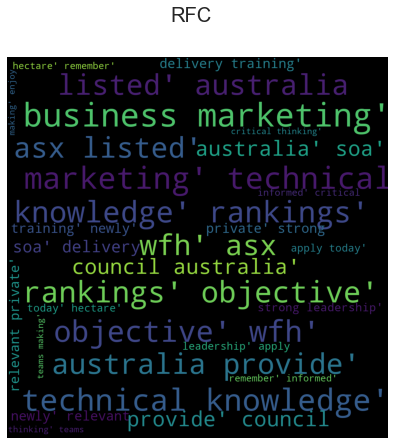

In [60]:
# wordcloud for the RF top features
show_wordcloud(rfc_feature_import.index.values[:30], title="RFC")

---
# 4.0 Question(s) 2

#### For the seecond assessment, two scenarios have been considered;
> 1. Job type - is there a discernable differentiation between Data Scientist and Data Analyst roles
> 2. Industry sector - is there a discernable differentiation between the 'Banking & Finance' and 'Government & Defence' sectors

Note that the salary information is not considered for Question 2 assessments. As such, the full data set can be used for the modelling

In [61]:
# clean copy of the full dataset - Note more data available now focus does not include salary
seek_cat = seek_all.copy()

---
## 4.1  Assessment 01: Data Scientist vs Data Analyst roles

### Q: what factors differentiate DS vs DA roles?


In [62]:
# check balance of the job types in the dataset
seek_cat['search'].value_counts(normalize=True)

Data Analyst      0.709848
Data Scientist    0.238599
Data Engineer     0.051553
Name: search, dtype: float64

In [63]:
# check unique types 
seek_cat['search'].unique()

array(['Data Scientist', 'Data Analyst', 'Data Engineer'], dtype=object)

<AxesSubplot:xlabel='search', ylabel='Count'>

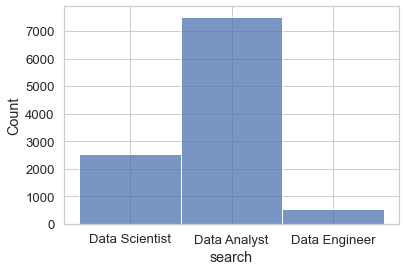

In [64]:
# generate histogram for broad stats review
sns.histplot(x=seek_cat['search'], palette='Purples')

> - Job types heavily imbalanced which will greatly affect the model performance
> - In order to create a balanced dataset, will randomly sample a number of DA jobs in the same magnitude of the DS and then combine to a single DF

In [65]:
# slice out DS jobs and assign to new DF
seek_job_type = seek_cat[seek_cat['search'] == 'Data Scientist']

In [66]:
# grab a random sample of datapoints from the Data Analyst jobs - perfectly balance for ease
da_sample = seek_cat[seek_cat['search'] == 'Data Analyst'].sample(n=2527, random_state=42)
seek_job_type = seek_job_type.append(da_sample, ignore_index=True)     #append to the DF with the Data Sci jobs

# Shuffle the DF rows to avoid any unwanted order in the Dataset that may impact the analyses
seek_job_type = seek_job_type.sample(frac=1).reset_index(drop=True)
seek_job_type.shape

(5054, 18)

In [67]:
# check resultant balance and baseline
seek_job_type['search'].value_counts(normalize=True)

Data Scientist    0.5
Data Analyst      0.5
Name: search, dtype: float64

> **Baseline accuracy** for classification = **50%**

In [68]:
# Feature and Targets
X_jt = seek_job_type.desc
y_jt = seek_job_type.search

# Splitsville
X_jt_train, X_jt_test, y_jt_train, y_jt_test = train_test_split(X_jt, y_jt, test_size=0.25, stratify=y_jt, random_state=42)

X_jt_train.shape, X_jt_test.shape

((3790,), (1264,))

---
### 4.1.1 -- Classification model 1: LogisticRegression

- Given that the problem has been boiled down to a binary classification problem, a Logistic Regressor has been employed.
- NB: in practice this may not be ideal given that once the job ad is vectorised, the Feature matrix is significantly wider (apprxo 2x in the final model). This may lead to overfitting with the LogReg.

#### Note to BF:
- originally ran a wider GridSearch with multiple params on the Vectoriser and a couple of penalities on the LogReg.
    - This resulted in significant runtime
- To reduce the runtime for future computations, I have reduced the Pipe params to match the best estimator that the Grid landed on

In [69]:
# pipeline set up with tokeniser and the classifier
pipe_lr = Pipeline([('vect', CountVectorizer(stop_words='english')), 
                    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))])

pipe_lr_params = {'vect__max_df': [0.15],
                  'vect__min_df': [3],
                  'vect__ngram_range': [(1,2)],
                  'vect__max_features': [10000],
                  'clf__penalty': ['l1']
                 }

lr_grid = GridSearchCV(pipe_lr, pipe_lr_params, cv=5)
lr_grid.fit(X_jt_train, y_jt_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(stop_words='english')),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             param_grid={'clf__penalty': ['l1'], 'vect__max_df': [0.15],
                         'vect__max_features': [10000], 'vect__min_df': [3],
                         'vect__ngram_range': [(1, 2)]})

In [70]:
# review the grid best parameters
lr_grid.best_params_

{'clf__penalty': 'l1',
 'vect__max_df': 0.15,
 'vect__max_features': 10000,
 'vect__min_df': 3,
 'vect__ngram_range': (1, 2)}

In [71]:
# print out the best score from the Training dataset
print("Best score from TRAIN data:\t", round(lr_grid.best_score_, 3))

# load the Grid outputs into a DF and isolate the best estimator outputs and check the X-fold results
lr_grid_results = pd.DataFrame(lr_grid.cv_results_)
lr_grid_results.iloc[:,10:][lr_grid_results['rank_test_score'] == 1]

Best score from TRAIN data:	 0.819


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.800792,0.828496,0.810026,0.829815,0.827177,0.819261,0.011711,1


In [72]:
## Check the TEST data
lr_best = lr_grid.best_estimator_
y_lr_pred_class = lr_best.predict(X_jt_test)

# confusion matrix on the TEST DATA
conmat = confusion_matrix(y_jt_test, y_lr_pred_class)
conf_df = pd.DataFrame(conmat, index=lr_grid.classes_, columns=lr_grid.classes_)

#print out the Classification rpt
print("--------Classification Results for TEST data--------\n")
print(classification_report(y_jt_test, y_lr_pred_class))

conf_df

--------Classification Results for TEST data--------

                precision    recall  f1-score   support

  Data Analyst       0.83      0.84      0.84       632
Data Scientist       0.84      0.83      0.84       632

      accuracy                           0.84      1264
     macro avg       0.84      0.84      0.84      1264
  weighted avg       0.84      0.84      0.84      1264



,Data Analyst,Data Scientist
Data Analyst,531,101
Data Scientist,106,526


#### Notes on model performance:
> - Reviewing the cross-fold scores from the training shows that overall the model variance is low and an 80% avg accuracy indicates relatively low bias.
> - The average TEST accuracy mirrors this performance with an avaerage accuracy of 83%. 
> - Similar Train and Test scores indicate a good fit for the model (i.e. no clear signs of over-fitting).
> - F1 scores are decent. Some Type 1 & 2 errors still remain. This could be expected given that in practice there is no industry accepted clear differentiation between Analyst/Scientist roles that all job ads adhere to. As such, there is likely some blurring between roles/responsibilities across the ads.

#### Check on the ROC/AUC characteristics

In [111]:
# probabilities for plotting
y_lr_probs = lr_best.predict_proba(X_jt_test)

#binarise the test labels for plotting
y_jt_test_bin = [0 if x == 'Data Analyst' else 1 for x in y_jt_test ]
y_jt_test_bin_da = [1 if x == 'Data Analyst' else 0 for x in y_jt_test ]

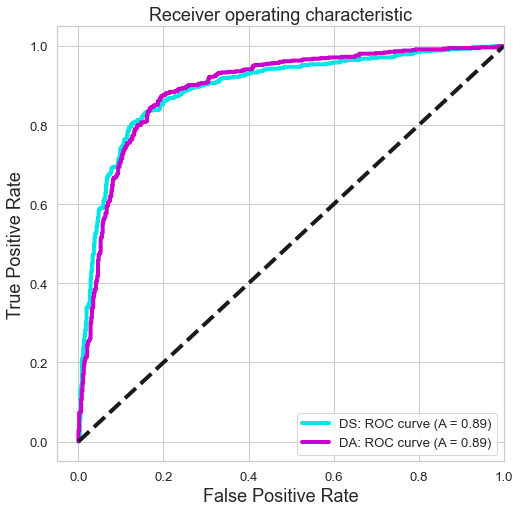

In [116]:
# plot for DS 
fpr, tpr, _ = roc_curve(y_jt_test_bin, y_lr_probs[:,1])
roc_auc = auc(fpr, tpr)
# plot for DA
fpr_da, tpr_da, _da = roc_curve(y_jt_test_bin_da, y_lr_probs[:,0])
roc_auc_da = auc(fpr_da, tpr_da)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='DS: ROC curve (A = %0.2f)' % roc_auc, linewidth=4, color='#00e6e6')
plt.plot(fpr_da, tpr_da, label='DA: ROC curve (A = %0.2f)' % roc_auc_da, linewidth=4, color='#cc00cc')

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [73]:
# access the grid pipeline chain to get the feature scores and the vectorised vocabulary
lr_jt_coefs = lr_grid.best_estimator_.named_steps['clf'].coef_
lr_jt_feat_names = lr_grid.best_estimator_.named_steps['vect'].vocabulary_

# chuck the log-prob for all features into a DF
lr_jt_feat_importance = pd.DataFrame(data = {'Coef': lr_jt_coefs[0]}, index=lr_jt_feat_names)

# sort for the max positive values as signifiers of Class "1" (DS)
lr_jt_feat_importance = lr_jt_feat_importance.sort_values(by=['Coef'], ascending=False)
lr_jt_feat_importance.head(20)

,Coef
rewards,5.380866
data analyst,3.696930
development processes,2.792385
business looking,2.687722
strong track,2.183258
ability collaborate,2.152807
media channels,2.116079
dimensional,1.969637
franchise,1.770616
auditing,1.709102


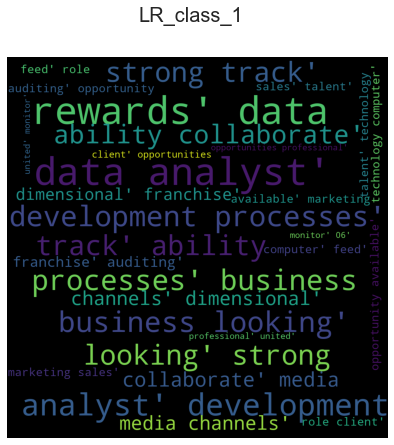

In [74]:
# wordcloud for the high-salary class
show_wordcloud(lr_jt_feat_importance.index.values[:30], title="LR_class_1")

In [75]:
# chuck the log-prob for all features into a DF
lr_jt_feat_importance = pd.DataFrame(data = {'Coef': lr_jt_coefs[0]}, index=lr_jt_feat_names)

# sort for the max negitive values as signifiers of Class "0" (DA)
lr_jt_feat_importance = lr_jt_feat_importance.sort_values(by=['Coef'], ascending=True)
lr_jt_feat_importance.head(20)

,Coef
core business,-2.115030
launched,-1.557802
skills good,-1.543754
critically,-1.543682
student outcomes,-1.489595
marketing strategy,-1.450393
family owned,-1.433457
industries including,-1.407259
degree computer,-1.358434
getting things,-1.318775


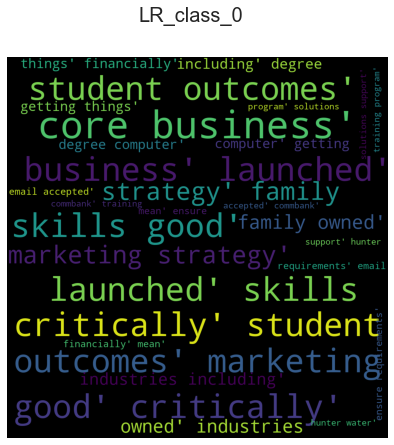

In [76]:
# wordcloud for the high-salary class
show_wordcloud(lr_jt_feat_importance.index.values[:30], title="LR_class_0")

---
### 4.1.2 -- Classification model 2: Tree of Life

In [77]:
# Set up a vectoriser with the same params as the LogisticRegression classification
vector_tree_jt = CountVectorizer(stop_words='english', max_df=0.15, max_features=10000, min_df=3, ngram_range=(1,2))

# down-to-matrix.... dtm's
X_train_dtm_tree_jt = vector_tree_jt.fit_transform(X_jt_train)    # Fit>Transform TRAIN data
X_test_dtm_tree_jt = vector_tree_jt.transform(X_jt_test)    # Transform TEST data

print(X_train_dtm_tree_jt.shape)

(3790, 10000)


In [78]:
# Try a Random Forest
rfc_jt = RandomForestClassifier(n_estimators=1000, oob_score=True)

forest_jt = cross_val_score(rfc_jt,X_train_dtm_tree_jt, y_jt_train, cv=5)
print("------TRAIN X-fold summary output ------")
print("Cross-fold scores: ",forest_jt)
print("Mean score:\t",round(np.mean(forest_jt),5))
print("St-dev:\t\t",round(np.std(forest_jt),5))

------TRAIN X-fold summary output ------
Cross-fold scores:  [0.83641161 0.84828496 0.86411609 0.85224274 0.85092348]
Mean score:	 0.8504
St-dev:		 0.00885


In [79]:
# fit the model on the full train dataset to gain access to the model goodies
rfc_jt.fit(X_train_dtm_tree_jt, y_jt_train)

RandomForestClassifier(n_estimators=1000, oob_score=True)

In [80]:
#
forest_pred_jt = rfc_jt.predict(X_test_dtm_tree_jt)
forest_score_jt = rfc_jt.score(X_test_dtm_tree_jt, y_jt_test)
print("RF Test score:", round(forest_score_jt,5))

# conf matrix on the TEST DATA
conmat = confusion_matrix(y_jt_test, forest_pred_jt)
conf_df = pd.DataFrame(conmat, index=rfc_jt.classes_, columns=rfc_jt.classes_)

#print out the Classification rpt
print("\n--------Classification Results for TEST data--------\n")
print(classification_report(y_jt_test, forest_pred_jt))

conf_df

RF Test score: 0.87816

--------Classification Results for TEST data--------

                precision    recall  f1-score   support

  Data Analyst       0.91      0.84      0.87       632
Data Scientist       0.85      0.91      0.88       632

      accuracy                           0.88      1264
     macro avg       0.88      0.88      0.88      1264
  weighted avg       0.88      0.88      0.88      1264



,Data Analyst,Data Scientist
Data Analyst,534,98
Data Scientist,56,576


#### Notes on model performance:
> - Reviewing the cross-fold scores from the training shows that overall the model has a slight decrease in variance compared to the Logistic Regression model, and the bias is slightly improved with scores edging closer to the truth.
> - The average TEST accuracy mirrors this performance.
> - There is an improvement in Type 1 errors with better precision of DS classifications
> - However, deciphering the Features of importance that will provide insights regarding each class is difficult from this model.

In [81]:
rfc_feature_import_jt = pd.DataFrame(data={'importance':rfc_jt.feature_importances_}, 
                                      index=vector_tree_jt.vocabulary_)
rfc_feature_import_jt.sort_values(by='importance', ascending=False, inplace=True)
rfc_feature_import_jt.head(20)

,importance
rewards,0.030906
data analyst,0.015036
murphy,0.009714
influential,0.009390
united,0.008670
strong track,0.006951
70,0.006770
online application,0.006506
encourage team,0.006449
business looking,0.006156


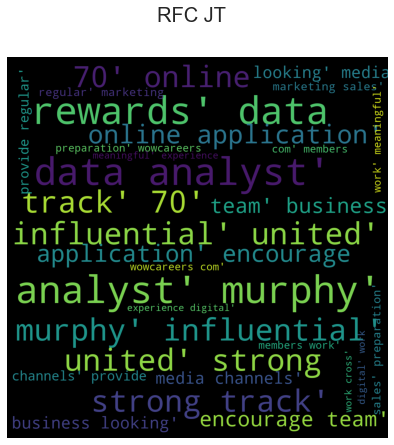

In [82]:
# wordcloud for the high-salary class
show_wordcloud(rfc_feature_import_jt.index.values[:30], title="RFC JT")

---
## 4.2  Assessment 2: Job sector 

### Q: what factors differentiate between two different industry sectors?

- Based on the breakdown of sectors within the full dataset, focus will be on the 'Banking & Financial Services' vs the 'Government & Defence' sectors, as these roles are expected to have different requirements and the subsets of data are fairly well balanced. 

In [83]:
seek_cat['sector_1'].value_counts()

Information & Communication Technology    4820
Marketing & Communications                 888
Government & Defence                       703
Accounting                                 662
Banking & Financial Services               619
Education & Training                       378
Science & Technology                       355
Mining, Resources & Energy                 272
Consulting & Strategy                      267
Manufacturing, Transport & Logistics       239
Engineering                                231
Sales                                      200
Administration & Office Support            188
Community Services & Development           120
Insurance & Superannuation                 112
Construction                                75
Real Estate & Property                      75
Retail & Consumer Products                  74
Advertising, Arts & Media                   70
Legal                                       67
Call Centre & Customer Service              66
Trades & Serv

In [84]:
seek_sector = seek_cat[(seek_cat['sector_1'] == 'Banking & Financial Services') |
                      (seek_cat['sector_1'] == 'Government & Defence')]

In [85]:
seek_sector.sector_1.value_counts(normalize=True)

Government & Defence            0.53177
Banking & Financial Services    0.46823
Name: sector_1, dtype: float64

> **Baseline accuracy** for classification = **53%**

In [86]:
# Feature and Targets
X_sec = seek_sector.desc
y_sec = seek_sector.sector_1

# Splitsville
X_sec_train, X_sec_test, y_sec_train, y_sec_test = train_test_split(X_sec, y_sec, 
                                                                    test_size=0.25, stratify=y_sec, random_state=42)

X_sec_train.shape, X_sec_test.shape

((991,), (331,))

---
### 4.2.1 -- Classification model 1: Base non-tree classifier

- SKLearn documentation notes that SVM mmodels are good for text/NLP problems. Decided to deploy a SGD Classifier here for an optimsied approach employing some regularisation
- SKLearn documentation notes that standardisation is important - additional standardscaler step included in Pipeline.

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

#### Note to BF:
- originally ran a wider GridSearch with multiple params - this resulted in significant runtime.
- To reduce the runtime for future computations, I have reduced the Pipe params to match the best estimator that the Grid landed on

In [88]:
# pipeline stuffs
pipe_sgd = Pipeline([('vect', CountVectorizer(stop_words='english')),
                    ('sclr', StandardScaler(with_mean=False)),
                    ('clf', SGDClassifier(max_iter=1000))])

pipe_sgd_params = {'vect__max_df': [0.15],
                  'vect__min_df': [4],
                  'vect__ngram_range': [(1,2)],
                  'vect__max_features': [10000],
                  'clf__penalty': ['l2']
                 }

sgd_grid = GridSearchCV(pipe_sgd, pipe_sgd_params, cv=5)
sgd_grid.fit(X_sec_train, y_sec_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(stop_words='english')),
                                       ('sclr',
                                        StandardScaler(with_mean=False)),
                                       ('clf', SGDClassifier())]),
             param_grid={'clf__penalty': ['l2'], 'vect__max_df': [0.15],
                         'vect__max_features': [10000], 'vect__min_df': [4],
                         'vect__ngram_range': [(1, 2)]})

In [89]:
# access the GRid best params
sgd_grid.best_params_

{'clf__penalty': 'l2',
 'vect__max_df': 0.15,
 'vect__max_features': 10000,
 'vect__min_df': 4,
 'vect__ngram_range': (1, 2)}

In [90]:
# print out the best score from the Training
print("Best score from TRAIN data:\t", round(sgd_grid.best_score_, 3))

# load the Grid outputs into a DF and isolate the best estimator outputs 
# and check the X-fold results
sgd_grid_results = pd.DataFrame(sgd_grid.cv_results_)
sgd_grid_results.iloc[:,10:][sgd_grid_results['rank_test_score'] == 1]

Best score from TRAIN data:	 0.919


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.909548,0.929293,0.939394,0.89899,0.919192,0.919283,0.014221,1


In [91]:
## Check the TEST data
sgd_best = sgd_grid.best_estimator_
y_sgd_pred_class = sgd_best.predict(X_sec_test)

# conf matrix on the TEST DATA
conmat = confusion_matrix(y_sec_test, y_sgd_pred_class)
conf_df = pd.DataFrame(conmat, index=sgd_best.classes_, columns=sgd_best.classes_)
#print out the Classification rpt
print("--------Classification Results for TEST data--------\n")
print(classification_report(y_sec_test, y_sgd_pred_class))

conf_df

--------Classification Results for TEST data--------

                              precision    recall  f1-score   support

Banking & Financial Services       0.94      0.93      0.94       155
        Government & Defence       0.94      0.95      0.94       176

                    accuracy                           0.94       331
                   macro avg       0.94      0.94      0.94       331
                weighted avg       0.94      0.94      0.94       331



,Banking & Financial Services,Government & Defence
Banking & Financial Services,144,11
Government & Defence,9,167


#### Notes on model performance:
> - Reviewing the cross-fold scores from the training shows that the model is low variance low bias.
> - The average TEST accuracy mirrors this performance. Test score is slightly better than the Training indicating a good fit.
> - F1 scores are great. Relatively low Type 1 & 2 errors.
> - Appears that there is a clear distinction between the sectors assessed.
> - However, high model accuracy is probably due to "Sector" terms being present in the job description block of text.
>
>
> - Coefficients of importance extracted relate to the factor that differentiate Class 1 (Government & Defence). Based on the top factors that were returned, this makes sense.

In [92]:
sgd_coefs = sgd_grid.best_estimator_.named_steps['clf'].coef_
sgd_feat_names = sgd_grid.best_estimator_.named_steps['vect'].vocabulary_

# # chuck the log-prob for all features into a DF
sgd_feat_importance = pd.DataFrame(data = {'Coef': sgd_coefs[0]}, index=sgd_feat_names)
sgd_feat_importance = sgd_feat_importance.sort_values(by=['Coef'], ascending=False)
sgd_feat_importance.head(20)

,Coef
relocation,46.144949
taxation,46.144949
advanced analytics,41.949954
email phone,29.653064
continuously,22.474796
initiatives including,20.336313
delivering unprecedented,19.395555
visa,19.304007
biodiversity,18.183332
23 june,18.183332


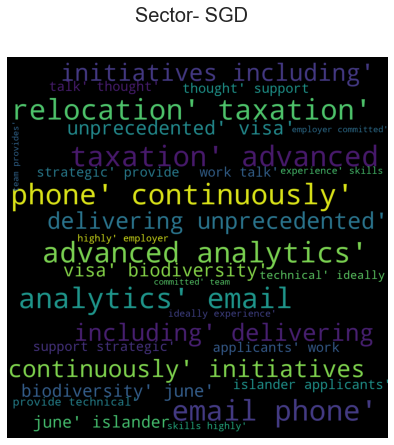

In [93]:
# wordcloud for the high-salary class
show_wordcloud(sgd_feat_importance.index.values[:30], title="Sector- SGD")

---
### 4.2.2 Industry Sector: Tree Classifier

In [94]:
# Set up a vectoriser with the same params as the LogisticRegression classification
vector_tree_sec = CountVectorizer(stop_words='english', max_df=0.15, max_features=10000, min_df=4, ngram_range=(1,2))

# down-to-matrix.... dtm's
X_train_dtm_tree_sec = vector_tree_sec.fit_transform(X_sec_train)    # Fit>Transform TRAIN data
X_test_dtm_tree_sec = vector_tree_sec.transform(X_sec_test)    # Transform TEST data

print(X_train_dtm_tree_sec.shape)

(991, 10000)


In [95]:
# Try a Random Forest
rfc_sec = RandomForestClassifier(n_estimators=1000, oob_score=True)

forest_sec = cross_val_score(rfc_sec,X_train_dtm_tree_sec, y_sec_train, cv=5)
print("------TRAIN X-fold summary output ------")
print("Cross-fold scores: ",forest_sec)
print("Mean score:\t",round(np.mean(forest_sec),5))
print("St-dev:\t\t",round(np.std(forest_sec),5))

------TRAIN X-fold summary output ------
Cross-fold scores:  [0.94472362 0.96969697 0.94444444 0.93939394 0.92929293]
Mean score:	 0.94551
St-dev:		 0.01332


In [96]:
# fit the model on the full train dataset to gain access to the model goodies
rfc_sec.fit(X_train_dtm_tree_sec, y_sec_train)

RandomForestClassifier(n_estimators=1000, oob_score=True)

In [97]:
#forest_pred = cross_val_predict(rfc,X_test_dtm_tree, y_test, cv=5)

forest_pred_sec = rfc_sec.predict(X_test_dtm_tree_sec)
forest_score_sec = rfc_sec.score(X_test_dtm_tree_sec, y_sec_test)
print("RF Test score:", round(forest_score_sec,5))

# conf matrix on the TEST DATA
conmat = confusion_matrix(y_sec_test, forest_pred_sec)
conf_df = pd.DataFrame(conmat, index=rfc_sec.classes_, columns=rfc_sec.classes_)
#print out the Classification rpt
print("\n--------Classification Results for TEST data--------\n")
print(classification_report(y_sec_test, forest_pred_sec))

conf_df

RF Test score: 0.94864

--------Classification Results for TEST data--------

                              precision    recall  f1-score   support

Banking & Financial Services       0.94      0.95      0.95       155
        Government & Defence       0.95      0.95      0.95       176

                    accuracy                           0.95       331
                   macro avg       0.95      0.95      0.95       331
                weighted avg       0.95      0.95      0.95       331



,Banking & Financial Services,Government & Defence
Banking & Financial Services,147,8
Government & Defence,9,167


#### Notes on model performance:
> - Generally the model performance is similar to the SVM classifier with low variance low bias.
> - The average TEST accuracy mirrors this performance. 
> - F1 scores are great. Relatively low Type 1 & 2 errors, however different balance in errors compared to the SVM classifier. The RandomFoest has given a blanced Type 1 & 2 error response.
> 
>
> - However, high model accuracy is probably due to "Sector" terms being present in the job description block of text.

In [98]:
rfc_feature_import_sec = pd.DataFrame(data={'importance':rfc_sec.feature_importances_}, 
                                      index=vector_tree_sec.vocabulary_)
rfc_feature_import_sec.sort_values(by='importance', ascending=False, inplace=True)
rfc_feature_import_sec.head(20)

,importance
certifications work,0.011100
thrive,0.011051
products services,0.009747
date thursday,0.008721
counted,0.008582
customer focussed,0.008576
awards,0.007041
thursday 24,0.005969
questions recruitment,0.005740
insurer,0.005365
